In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.helper_functions import *

# Handling text 2 exercise
[Handling text exercisses ADApted drom ADA 2018 final exam]

The Sheldon Cooper we all know and love (OK, some of us might not know him, and some might not love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove. The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Task A: Picking up the shovel

**Note: You will use the data you preprocess in this task in all the subsequent ones.**

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); **you must discard these lines**, for the sake of simplicity. However, you do not need to do it for Q1 in this task -- you'll take care of it when you solve Q2.

**Q1**. Your first task is to extract all lines of dialogue in each scene and episode, creating a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself. You do not need to extract the proper name of the episode (e.g. episode 1 can appear as "Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot Episode"). Then, answer the following question: In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**

In [5]:
line = '>> Series 01 Episode 01 – Pilot Episode'
line[3:]

'Series 01 Episode 01 – Pilot Episode'

In [7]:
# your code goes here
season = ""
episode = ""
scene = ""
data = []
with open("data/all_scripts.txt") as f:
    for line in f.readlines():
        line = line[:-1]
        if line.startswith('>>'):
            season = int(line[10:12])
            episode = line[3:]
            continue
        if line.startswith("> "):
            scene = line[2:]
            continue
        character, line = line.split(": ", 1)
        data.append([season, episode, scene, character, line])

In [12]:
lines = pd.DataFrame(data, columns=["Season", "Episode", "Scene", "Character", "Line"])

In [24]:
len(set(lines.Scene))

901

In [22]:
lines.groupby(["Season", "Episode", "Scene"]).count().reset_index().groupby("Season").count()[["Scene"]]

,Scene
Season,
1,157
2,205
3,193
4,219
5,198
6,211
7,207
8,191
9,177


**Q2**. Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. To remove that character, pay attention to the _named character_ assumption we gave you earlier on. **For all the subsequent questions, you must only keep the dialogue lines said by the recurrent characters in your list.**

In [27]:
lines_per_chars = lines.groupby("Character").count()[["Line"]]
recurrent_chars = lines_per_chars[lines_per_chars["Line"] > 90]
recurrent_chars

,Line
Character,
Amy,3472
Arthur,130
Bernadette,2690
Bert,95
Beverley,162
Emily,164
Howard,5872
Kripke,106
Leonard,9829


## Task B: Read the scripts carefully

### Part 1: Don't put the shovel down just yet

**Q3**. From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for all the questions in this task.**

In [28]:
# your code goes here
def clean_line(line):
    for char in EXCLUDE_CHARS:
        line = line.replace(char, ' ')
    return line.lower()
lines["Line"] = lines["Line"].apply(clean_line)
lines.head()

,Season,Episode,Scene,Character,Line
0,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,so if a photon is directed through a plane wit...
1,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,agreed what s your point
2,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,there s no point i just think it s a good ide...
3,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,excuse me
4,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Receptionist,hang on


**Q4**. For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

In [32]:
# your code goes here
corpus_frequency = pd.concat([pd.Series(row['Line'].split(' ')) for _, row in lines.iterrows()]).reset_index()
corpus_frequency.columns = ["Frequency", "Word"]
corpus_frequency = corpus_frequency.groupby("Word").count()

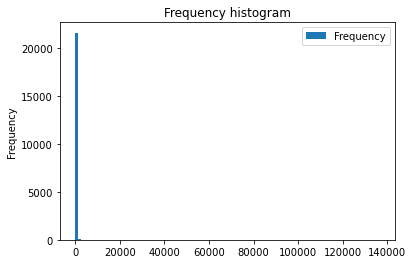

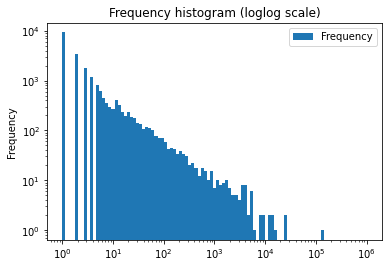

In [35]:
corpus_frequency.plot.hist(by="Frequency", bins=100, title="Frequency histogram")
corpus_frequency.plot.hist(by="Frequency", loglog=True, bins=np.logspace(0, 6, 100),
                           title="Frequency histogram (loglog scale)");

### Part 2: Talkativity
**Q5**. For each of the recurrent characters, calculate their total number of words uttered across all episodes. Based on this, who seems to be the most talkative character?

In [46]:
# your code goes here
lines["Words"] = lines["Line"].apply(lambda x: len(x.split(' ')))
words_per_char = lines.groupby('Character').sum()['Words']
words_per_char[recurrent_chars.index]

Character
Amy              47997
Arthur            1933
Bernadette       33510
Bert              1407
Beverley          2447
Emily             1930
Howard           84388
Kripke            1538
Leonard         126078
Leslie            1541
Man               1552
Mrs Cooper        4060
Mrs Wolowitz      1757
Penny            99517
Priya             2424
Raj              73039
Sheldon         223272
Stuart            9773
Wil               2022
Zack              1775
Name: Words, dtype: int64

In [44]:
recurrent_chars.index

Index(['Amy', 'Arthur', 'Bernadette', 'Bert', 'Beverley', 'Emily', 'Howard',
       'Kripke', 'Leonard', 'Leslie', 'Man', 'Mrs Cooper', 'Mrs Wolowitz',
       'Penny', 'Priya', 'Raj', 'Sheldon', 'Stuart', 'Wil', 'Zack'],
      dtype='object', name='Character')

## Task D: The Detective's Hat

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high. Leonard also suspects that it's easier for Sheldon to distinguish the lines that _aren't_ his, rather than those that _are_. We want you to put on the (proverbial) detective's hat and to investigate this claim.

**Q6**. Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons. Each of your data points (which is one row of your matrix) is one **dialogue line**. Now, use the scikit-learn class **TfIdfVectorizer** to create TF-IDF representations for the data points in your training and test sets. Note that since you're going to train a machine learning model, everything used in the training needs to be independent of the test set. As a preprocessing step, remove stopwords and words that appear only once from your vocabulary. Use the simple tokenizer provided in `helpers/helper_functions.py` as an input to the TfidfVectorizer class, and use the words provided in `helpers/stopwords.txt` as your stopwords.

In [47]:
# your code goes here
train_set = lines[lines["Season"] <= lines["Season"].max() - 2]
test_set = lines[lines["Season"] > lines["Season"].max() - 2]

In [54]:
stop_words = []
with open("helpers/stopwords.txt") as f:
    for line in f.readlines():
        stop_words.append(line[:-1])

In [55]:
tfidf = TfidfVectorizer(stop_words=stop_words, tokenizer=simple_tokeniser, min_df=2)
train_vectors = tfidf.fit_transform(train_set["Line"])
test_vectors = tfidf.transform(test_set["Line"])

**Q7**. Find the set of all words in the training set that are only uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.

In [63]:
# your code goes here
words_for_chars = pd.concat([pd.Series(row["Character"], row['Line'].split(' '))
                             for _, row in lines.iterrows()]).reset_index()
words_for_chars.columns = ["Word", "Character"]

In [64]:
words_for_chars = words_for_chars.groupby("Word")["Character"].apply(set)

Word
         {Gablehouser, Red-haired guy, Shopkeeper, Stra...
0                        {Howard, Leonard, Missy, Sheldon}
00                                  {Amy, Howard, Leonard}
000      {Bernadette, Stuart, Leonard, Howard, Sheldon,...
000lb                                            {Sheldon}
                               ...                        
…tion                                            {Sheldon}
…when                                              {Penny}
…who                                             {Leonard}
‭yeah                                            {Leonard}
♪                                                    {Amy}
Name: Character, Length: 21692, dtype: object

In [72]:
for i, char in enumerate(words_for_chars):
    print(words_for_chars.index[i])


0
00
000
000lb
01100111
0110111001101111
03
04
0400
05
06
0700
08
0about
1
10
100
1000
101
102
104
10pm
10th
11
110
112
114
1150
1175
118
11n
11pm
11th
12
120
123
125
128
12th
13
130
137
14
140
144
1487
14th
15
150
1500s
154
156
15th
15…
16
160th
1619
162
1642
165
168
16th
17
170
171
172
174
175
1778
17th
18
180
1800
1800s
183
1852
1855
1859
1863
1865
187
1876
1880s
1890
1890s
18am
18th
19
1900s
1908
1911
1915
1917
193
1930
1930s
1935
1936
1940
1940s
1944
1946
1948
1952
1955
1956
1960s
1964
1965
1969
1970s
1974
1975
1976
1977
1979
1980
1980s
1982
1989
1992
1993
1995
1998
1999
19th
1am
1b
2
20
200
2000
2001
2003
2004
2005
2006
2007
2008
2009
200million
2012
2015
204
209
2099
20s
20th
21
210
211
21185
212
21st
22
220
22nd
23
2311
232
2328
233
235
238
23rd
24
245
246
248
25
250
2530
25th
26
27
2711
273
28
288
289
28th
29
290
294
295118
2a
2am
3
30
300
3000
300th
30pm
30s
30th
31
311
317
32
320
33
34
3400
35
350
359
36
360
364
366…
367…
369
37
37b
38
380
383
39
390
3d
3p
3po
3rd
4
40
400l

banjo
bank
banking
banks
banned
banner
banquet
banter
bappu
bar
barbara
barbarian
barbarians
barbaric
barbecue
barbeques
barber
barbering
barbershop
barbie
barbs
barcodes
bare
bareback
barefoot
barehanded
barely
bargain
barge
barging
barium
bark
barkeep
barking
barmaid
barn
barnabas
barnard
barnett
barney
barnum
barrel
barreling
barrelling
barrels
barren
barrette
barrettes
barrier
barriers
barry
bars
bart
bartender
bartenders
baruch
basal
base
baseball
based
baseline
basement
baser
bases
bash
bashed
bashing
basic
basically
basics
basing
basis
basket
basketball
baskets
baskin
bass
bassinet
bastard
bastards
bastard…
baster
basting
bat
batch
batchelor
batcrap
batgirl
bath
bathe
bathed
bathing
bathrobe
bathroom
baths
bathtub
bathtubs
bathwater
batman
batmobile
batmobile…
bats
batsuit
battalion
batter
battered
batteries
battery
battle
battled
battlefield
battles
battleship
battlestar
battling
baum
bavarian
bawance
bawwel
bawwoons
bawwy
bawy
bay
bayberry
baybrook
bayonets
bazinga
bazongas
ba

cattle
catty
cattywampus
catwoman
catwomen
caught
causal
causality
cause
caused
causes
causing
caution
cautious
cautiously
cavalier
cavalry
cavanaugh
cavawier
cave
caveman
caves
caviar
cavities
cavity
cavorting
caw
caweer
cayman
cañada
cbc
cd
cdm
ceases
cedar
cedric
ceiling
ceilings
celebrate
celebrated
celebrating
celebration
celebratory
celebrities
celebrity
celestial
cell
celled
cellist
cello
cells
cellular
celsius
cement
cemented
cemetery
cent
centauri
center
centers
centimetre
centimetres
central
centre
centred
centres
centric
centrifugal
centrifuge
centripetal
cents
centuries
century
ceramic
cereal
cereal…
cerebral
ceremony
cern
cersei
certain
certainly
certainty
certificate
cervix
cetera
ceti
cha
chad
chafed
chafing
chai
chain
chained
chains
chainsaw
chains…
chair
chairman
chairs
chalk
challenge
challenged
challenges
challenging
chamber
chambourg
chamomile
champagne
champion
champions
championship
chan
chance
chancellor
chances
chanel
chang
change
changed
changer
changeroni
chan

cylons
cymbal
cyrus
cyst
czech
czechoslovakia
c…
d
d2
d7
da
dab
dad
daddies
daddy
daddy…
dads
dad”
daffodils
dag
dagger
dagobah
dah
daily
daily…
dairy
daisy
dakota
daleks
dalib
dallas
dalliance
dally
dalmatians
dam
damage
damaged
damaged…
dame
dammit
damn
damnation
damned
damp
damper
dampness
dams
damsel
dan
dance
dancer
dancers
dances
dancing
dancing…
dander
dandruff
dandy
danes
dang
danger
dangerous
dangers
dangle
dangles
daniel
danish
danny
danube
danza
daq
dare
dared
daredevil
daring
dark
darkened
darker
darkest
darkness
darlin
darling
darmspülung
darn
darned
darnedest
darrow
dart
darth
darts
darwin
das
dashboard
dashing
dastardly
dat
data
database
data…
date
dated
dateline
dates
date…
dating
dating”
daughter
daughters
daunting
dave
davenport
david
davis
davy
dawg
dawn
dawning
day
dayaj
daydream
daylight
days
daytime
day…
dazzle
dc
ddr3
de
dead
deadliest
deadline
deadly
deadpool
deaf
deal
dealer
dealership
dealing
deals
dealt
deal…
dear
death
deathbed
deaw
deb
debakey
debate
debati

every…
ever…
evewybody
evewyone
evict
eviction
evidence
evidenced
evident
evidently
evid…
evil
evite
evolution
evolutionary
evolve
evolved
evolving
ew
ewok
ewoks
eww
ewwy
ex
exact
exactly
exaggerate
exaggerated
exaggeratedly
exaggeration
exam
examination
examine
examines
examining
example
examples
exams
exasperated
exasperation
excalibur
exceeded
exceeding
exceedingly
exceeds
excel
excelled
excellent
excelsior
except
exception
exceptional
exceptions
excess
exchange
exchanged
exchanges
exchanging
excitation
excite
excited
excited”
excitement
exciting
exclude
excluded
excluding
exclusive
excrement
excusable
excuse
excused
excuses
execute
executed
execution
executive
exercise
exercises
exercising
exes
exfoliated
exhale
exhaust
exhausted
exhausting
exhaustion
exhibit
exhibiting
exhibition
exhibits
exhilarating
exiled
exist
existed
existence
existent
existing
exists
exit
exiting
exits
exoskeleton
exothermic
exotic
expand
expanded
expander
expanding
expands
expansion
expect
expectant
expecta

grandfather
grandkids
grandma
grandmas
grandmother
grandmothers
grandpa
grandparents
grandson
granite
granny
granola
grant
granted
grants
grape
grapefruit
grapes
grapes…
graphene
graphic
graphics
gras
grasp
grasping
grass
grasshopper
grasshoppers
grateful
gratify
gratitude
grave
gravel
gravelly
graveyard
gravitas
gravitational
gravities
gravity
gravity…
gravy
gray
grayson
graziano
grease
greaseboards
greasy
great
greater
greatest
greatly
greatness
great…
greece
greece…
greedy
greej
greek
greeks
green
greene
greener
greet
greeting
greetings
gremlins
grenade
grenades
gretchen
grew
grey
greyhound
greyjoy
grid
grief
griffin
griffith
grill
grilled
grilling
grim
grinch
grind
grinding
grip
gripping
grips
grisham
groan
groceries
grocers
grocery
groin
groom
groomed
groomer
groomsman
groot
groove
grope
groped
gross
grossinger
grossman
grotesque
grouch
ground
groundbreaking
grounded
grounds
groundwork
group
groupies
groupings
groupon
groups
grove
grovel
groveller
grovelling
grover
grow
growing
gr

jacques
jacuzzi
jacuzzis
jaguar
jail
jailor
jajvam
jake
jam
jamaican
jamb
jamba
jamboree
james
jameson
jamma
jammed
jammy
jan
jane
jangle
jangling
janine
janitor
janko
january
japan
japanese
japes
jar
jars
jasmine
jason
jaundice
java
jaw
jawas
jaws
jay
jaywalk
jaywalked
jazz
je
jealous
jealousy
jean
jeanie
jeans
jedi
jeebie
jeebies
jeepers
jeeves
jeez
jeff
jeffries
jekyll
jell
jello
jelly
jellyfish
jemima
jenga
jennifer
jenny
jenny309
jenofski
jensen
jenson
jeopardize
jeopardizes
jeopardizing
jeopardy
jerk
jerkface
jerks
jerky
jerry
jersey
jerusalem
jesse
jessica
jest
jester
jesus
jet
jets
jettison
jew
jewel
jewelled
jewellery
jewels
jewish
jews
jibber
jibberjabber
jif
jiffy
jifs
jiggle
jiggling
jim
jiminy
jimmy
jims
jingle
jingles
jinks
jisovbe
jitters
jive
jlyajbe
jo
joanie
job
jobs
jock
jockey
jockeys
jocks
joe
joel
joes
joey
joffrey
jog
jogger
jogging
jogs
johansson
john
johnny
johnson
join
joined
joining
joins
joint
jointly
joints
joke
joker
jokes
joking
jolie
jolly
jon
jonah
jona

moisturizing
mojo
molar
moldova
mole
molecular
molecule
molecules
moles
mollified
molten
moly
molybdenum
mom
moment
momentito
momento
moments
momentum
moment…
momma
mommies
mommy
moms
mom…
mon
mona
monaco
monday
mondays
money
moneymaker
mongoose
mongrel
monica
monitor
monitoring
monk
monkey
monkeys
monoamine
monocle
monogamous
monogrammed
monolithic
monomers
monopole
monopoles
monopoly
monoxide
monroe
monrovia
monsoon
monster
monsters
monstrosity
montage
montana
monte
montessori
montgomery
month
monthly
months
montoya
monty
monuments
moo
mooch
mooched
mooching
mood
moody
moon
moondance
moonlight
moons
moore
moose
moot
mop
mope
moping
moral
morale
morality
morally
morals
moranelli
morbid
morbidly
mordor
more
morelost
mores
more…
morgue
morlocks
mornin
morning
mornings
moron
morphed
morrisette
morse
morsel
morta
mortadella
mortal
mortem
mortgages
mortified
morton
morty
moscow
moses
mosey
mosquitoes
mosquitos
moss
mossbacher
most
mostly
motel
moth
mother
mothers
mothlike
moths
mothy
motio

pioneer
pip
pipe
pipes
pippin
piqued
piracy
pirate
pirates
pisces
pish
pishkin
piss
pissed
pistachio
pistachios
pistols
pit
pitch
pitched
pitcher
pitchers
pitfalls
pits
pitted
pity
pivot
pivotal
pivoting
pixels
pixie
pizza
pizzas
piña
piñatas
pj
pjs
pkshhhh
pl
place
placebo
placed
placement
places
placinex
plagiarizing
plague
plagued
plaid
plain
plan
planck
plancovik
plane
planes
planet
planetarium
planetary
planetes
planetoid
planets
planet”
planko
planned
planner
planning
plans
plans…
plant
plantation
planted
planter
plants
plant…
plaque
plaques
plasma
plaster
plastered
plastic
plasticised
plate
plateful
plates
platform
platitude
platonic
platonically
platter
platypus
plausible
plausibly
play
playa
playbook
playboy
playdate
playdates
played
player
players
playful
playfully
playfulness
playground
playin
playing
playing…
playlist
plays
playstation
playtime
plea
plead
pleas
pleasant
pleasantly
pleasantries
please
pleased
please…
pleasing
pleasingly
pleasure
pleasures
pleasuring
pleathe


renting
rents
reopen
reopening
rep
repaint
repair
repaired
repairs
repartee
repay
repeal
repeat
repeated
repeatedly
repeater
repeating
repeats
repellent
repentance
repetition
rephrase
rephrased
replace
replaced
replacement
replaces
replacing
replica
replicas
replicate
replies
reply
report
reported
reporter
reporting
reports
reposition
represent
representation
representative
represented
representing
represents
reprinting
reproduce
reproduction
reproductive
reprogram
reprogrammed
reprogramming
reps
reptile
republic
repulse
repulsed
repurposes
reputation
repute
request
requested
requesting
require
required
requirement
requirements
requires
requiring
rerun
rescind
rescinded
rescue
rescued
rescuing
research
researcher
researchers
researching
research…
reseda
resemblance
resemble
resent
reservation
reservations
reserve
reserved
reserving
reservoir
reset
resetting
reshaped
residence
resident
residents
resides
residing
residual
residue
resignation
resigned
resin
resist
resistance
resistant
res

sowwy
sowy
soy
soyuz
so…
so…7
spa
space
spacecraft
spaced
spaces
spaceship
spacex
spacing
spacious
spades
spaghetti
spam
span
spanish
spank
spanking
spanx
spare
spark
sparkle
sparkles
sparkletts
sparkling
sparkly
sparks
sparring
sparsely
sparta
spas
spasming
spat
spatial
spay
speak
speaker
speakerphone
speaking
speaking…
speaks
spear
spearmint
spears
special
specialist
specialize
specialized
specials
specialties
specialty
species
specific
specifically
specifications
specificity
specified
specifies
specify
specimens
speckerman
specs
spectacle
spectacular
spectral
spectre
spectrometer
spectroscopy
spectrum
speculate
speech
speeches
speechless
speed
speeder
speeding
speedos
speedy
spell
spellcasters
spelled
spells
spelunking
spend
spending
spends
spendy
spent
sperm
spewers
spewing
sphere
spherical
sphincter
sphincters
sphygmomanometer
spice
spiced
spices
spicy
spider
spiderman
spiders
spidey
spielberg
spies
spike
spiked
spiking
spill
spilled
spilling
spilt
spin
spinach
spinal
spine
spinel

trifecta
trigger
triggered
triggering
trilemma
trilogy
trim
trimester
trimming
trio
trip
triphasic
triple
tripped
tripping
trips
triptych
triumph
triumphant
triumphs
trivia
trivial
trix
trixie
troglodytes
trois
trojan
troll
trolley
trolling
trolls
tron
troop
troopers
trooping
troops
trophies
trophy
tropical
tropicana
trotted
trouble
troubled
troubles
troubleshoot
troubling
trouper
trouser
trousers
troy
truce
truck
trucker
trucks
truck… 
trudged
true
truffles
truly
truly…
trump
trumpeting
trumps
trundle
trunk
trunks
trust
trusted
trusting
trustworthy
truth
truthful
truthfully
truthful…
try
trying
tryouts
tsa
tso
tu
tub
tuba
tubby
tube
tubes
tubing
tubold
tubs
tucci
tuchus
tuck
tucked
tuckered
tucking
tucks
tuckus
tuesday
tuesdays
tug
tugging
tuk
tukus
tumbler
tumbleweeds
tumor
tumour
tums
tuna
tunder
tundra
tune
tuned
tunes
tuning
tunnel
tunnelling
tunnels
tupperman
tupperware
tur
turban
turbine
turbo
turbulence
turd
turf
turing
turkey
turmoil
turn
turnabout
turncoat
turned
turning
turn

संगीत
–
‘arrah
‘bye
‘cause
‘cos
‘course
‘em
‘er
‘im
‘iv
‘kay
‘m
‘n
‘s
‘stead
‘sup
‘supernova
‘til
‘tombo
‘which
“a
“aaaaaaa”
“ah
“any
“are
“awesome”
“bazinga”
“blublublublublublublublu”
“bob
“buy
“buzz”
“b”
“check
“cohabitation”
“come
“crash”
“crushers
“damsel
“dave
“deal”
“die
“do
“dude
“dumbass”
“fever
“frankly
“get
“girlfriend
“grown
“ha
“has
“has”
“have
“he
“here
“hey
“how
“huzzah
“i
“if
“in
“incorrect”
“intruder
“it
“jimmy”
“kandorian
“larger
“leonard
“lol
“long
“me
“must
“möchtest
“need
“no
“normally
“oh
“oh”
“only
“ooh
“oops
“p
“penny
“please
“priya
“problem
“pumpernickel”
“release
“ridiculous
“rocket
“sarcasm”
“science
“smart
“soft
“speed
“sure
“surprise
“sweet
“tear
“thanks
“the
“there
“this
“three
“time
“waltz”
“we
“well
“wesley”
“what
“who
“why
“will
“with
“world
“would
“ye
“yeah
“yo
“you
”
…
…and
…bernadette
…chinese
…playing
…she
…spoiled
…the
…thing
…thousand
…tion
…when
…who
‭yeah
♪


In [73]:
sheldon = []
for i, char in enumerate(words_for_chars):
    if 'Sheldon' in char and len(char) == 1:
        sheldon.append(words_for_chars.index[i])

In [78]:
len(sheldon)

5334

In [76]:
#words_for_chars = words_for_chars.groupby("Word")["Character"].apply(set)
sheldon_words = words_for_chars[words_for_chars.apply(lambda x: ("Sheldon" in x) and (len(x) == 1))].index

In [79]:
def contains_sheldon_words(line):
    for word in sheldon_words:
        if word in line:
            return True
    return False
test_pred = test_set["Line"].apply(contains_sheldon_words)
test_true = test_set["Character"] == "Sheldon"

In [81]:
print("Accuracy: ", (test_true == test_pred).sum() / len(test_true))

Accuracy:  0.3656061437191443


**Q8**. Now, perform singular value decomposition (SVD) on the training TF-IDF matrix, and calculate a **25-dimensional approximation** for both the training and test TF-IDF matrices (you can do this using scikit-learn's **TruncatedSVD** class). Then, train a logistic regression classifier with 10-fold cross-validation (using the scikit-learn **LogisticRegressionCV** class) on the output of the SVD that given a dialogue line, tells you whether it's by Sheldon or by someone else.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**i)** Report precision, recall and F1-score for both classes (Sheldon and not-Sheldon), as well as accuracy, of your classifier on the training set and the test set. You need to implement the calculation of the evaluation measures (precision, etc.) yourself -- using the scikit-learn functions for them is not allowed.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**ii)** What difference do you observe between the model's scores on the training and test sets? What could you infer from the amount of difference you see? What about the difference between scores on the two classes? Given the performance of your classifier, is Leonard right that the accuracy Sheldon claims is unattainable? What about his suspicions about the lines that Sheldon can and cannot distinguish?
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**iii)** List 10 of the most extreme false positives and 10 of the most extreme false negatives, in terms of the probabilities predicted by the logistic regression model. What are common features of false positives? What about the false negatives?
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**iv)** What is the most important feature in the model? What are the 5 most important words in this feature? _Hint: Think of the definition of an SVD, and that you did an SVD on the TF-IDF matrix with dialogue lines as rows and words as columns. You have projected the original data points onto a 25-dimensional subspace -- you need to look at the unit vectors you used for the projection._

In [82]:
svd = TruncatedSVD(n_components=25)
train_svd = svd.fit_transform(train_vectors)
test_svd = svd.transform(test_vectors)

In [18]:
model = LogisticRegressionCV(cv=10)
train_labels = train_set["Character"] == "Sheldon"
model.fit(train_svd, train_labels)
test_pred = model.predict(test_svd)
train_pred = model.predict(train_svd)

In [19]:
def confusion_matrix(test, pred, positive=1):
    negative = 0 if positive == 1 else 1
    cm = np.zeros((2,2))
    test = test.values
    cm[0,0] = np.logical_and(pred == positive, test == positive).sum()
    cm[0,1] = np.logical_and(pred == positive, test == negative).sum()
    cm[1,0] = np.logical_and(pred == negative, test == positive).sum()
    cm[1,1] = np.logical_and(pred == negative, test == negative).sum()
    df = pd.DataFrame(cm.astype(int), columns=["Positive", "Negative"])
    df.index = ["Positive Prediction", "Negative Prediction"]
    return df

def accuracy(confusion_matrix):
    return (confusion_matrix[0,0] + confusion_matrix[1,1]) / confusion_matrix.sum()

def precision(confusion_matrix):
    if (confusion_matrix[0,:].sum() == 0):
        return 1
    return confusion_matrix[0,0] / confusion_matrix[0,:].sum()

def recall(confusion_matrix):
    if (confusion_matrix[:,0].sum() == 0):
        return 1
    return confusion_matrix[0,0] / confusion_matrix[:,0].sum()

def fscore(confusion_matrix):
    p = precision(confusion_matrix)
    r = recall(confusion_matrix)
    return 2 * p * r / (p+r)

def stats(confusion_matrix):
    confusion_matrix = confusion_matrix.values
    return {"accuracy": accuracy(confusion_matrix), "precision":precision(confusion_matrix),
            "recall": recall(confusion_matrix), "fscore": fscore(confusion_matrix)}

print("Statistics for class 1 on train set:\n", stats(confusion_matrix(train_labels, train_pred, positive=1)))
print("Statistics for class 0 on train set:\n", stats(confusion_matrix(train_labels, train_pred, positive=0)))
print("Statistics for class 1 on test set:\n", stats(confusion_matrix(test_true, test_pred, positive=1)))
print("Statistics for class 0 on test set:\n", stats(confusion_matrix(test_true, test_pred, positive=0)))

Statistics for class 1 on train set:
 {'accuracy': 0.7660207166575804, 'precision': 0.5190839694656488, 'recall': 0.014388489208633094, 'fscore': 0.02800082355363393}
Statistics for class 0 on train set:
 {'accuracy': 0.7660207166575804, 'precision': 0.7676344407861918, 'recall': 0.9959225940068605, 'fscore': 0.8670028453108715}
Statistics for class 1 on test set:
 {'accuracy': 0.7942951179374658, 'precision': 0.25925925925925924, 'recall': 0.0031291908806437194, 'fscore': 0.006183745583038869}
Statistics for class 0 on test set:
 {'accuracy': 0.7942951179374658, 'precision': 0.7956190999908349, 'recall': 0.9977014136306172, 'fscore': 0.8852743218437691}


The fscore on class 1 is low for both the train and test sets. This is due to bad recall for both, as it means our True-Positive Rate is bad (only few of the elements categorized as positive are actually positive). This is not the case for class 0, which means that our model is actually better at detecting if a line is not from Sheldon, rather than to detect if it is from him.

In [20]:
proba = model.predict_proba(test_svd)
to_class = lambda x: [0, 1] if x == 1 else [1, 0]
test_class = np.array([to_class(i) for i in test_true])
pred_class = test_class * proba

In [21]:
print("10 most extreme false negatives")
test_set.iloc[pred_class[:,0].argsort()[:10]]["Line"].values

10 most extreme false negatives


array([' knock  knock  knock  amy   knock  knock  knock  amy   knock  knock  knock  amy  will you marry me ',
       'look  it s the same smile she has in the painting ',
       'yeah  it seems only right that she have it back ',
       'it truly does capture the beauty of your friendship with penny ',
       'sexual insecurity ',
       'you know  i wonder how she feels about all this artwork ',
       'you know  i have always thought that this couch would look fantastic on the curb in front of the building ',
       'kind of a wuss ',
       'let s take every single thing from the other apartment and put it in here ',
       'oh  actually  i would '], dtype=object)

In [22]:
print("10 most extreme false positives")
test_set.iloc[pred_class[:,1].argsort()[:10]]["Line"].values

10 most extreme false positives


array(['so  what package are you thinking ',
       'you re right  it sells itself ',
       'you have to admit  it s a pretty smooth ride ',
       'i was hoping it d be quieter ',
       'if childbirth is half this bad  you are so screwed  are we there yet ',
       'soon ', 'why is it taking so long ',
       'fine  we ll go to the e r  just stop selling me on the van ',
       'howard  howard  look at the dvd screen  i put on batman  the animated series  your favourite ',
       'i ve been babysitting him way longer than you have '],
      dtype=object)

In [23]:
best_components = np.abs(svd.components_).argmax(axis=1)
list(np.array(tfidf.get_feature_names())[best_components])

['hey',
 'hey',
 'sheldon',
 'right',
 'really',
 'well',
 'thank',
 'going',
 'thank',
 'good',
 'sure',
 'sorry',
 'sorry',
 'want',
 'leonard',
 'get',
 'come',
 'like',
 'hi',
 'penny',
 'great',
 'hello',
 'll',
 'got',
 'say']

In [9]:
# your code goes here